In [1]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import keras

from keras.utils import image_dataset_from_directory, load_img, img_to_array
from keras.optimizers import Adam
from keras.models import load_model
from keras import layers

from functions.visual import showcase_augmented_image, create_confusion_matrix
from functions.evaluate import eval_model_stats, plot_model_peformance_from_df

# Dataset preprocessing

## Load Data from Directory

Load data using a Keras utility

In [22]:

img_shape = (48,48) #shape of image
BS = 16 #batch size per iteration of sequence
dir_train_images = 'data/Training'
dir_test_images = 'data/Test'

train_ds = image_dataset_from_directory(
    dir_train_images,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=img_shape,
    batch_size=BS,
    color_mode = 'grayscale',
    labels = 'inferred'
)

val_ds = image_dataset_from_directory(
    dir_train_images,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=img_shape,
    batch_size=BS,
    color_mode = 'grayscale',
    labels = 'inferred'

)

test_ds = image_dataset_from_directory(
    dir_test_images,
    seed=1337,
    image_size=img_shape,
    batch_size=BS,
    color_mode = 'grayscale',
    labels = 'inferred'
)

class_names = train_ds.class_names #list of class labels 
num_cat = len(class_names) #number of classes

Found 27463 files belonging to 7 classes.
Using 21971 files for training.
Found 27463 files belonging to 7 classes.
Using 5492 files for validation.
Found 6584 files belonging to 7 classes.


## Augment Dataset

Increase the diversity of training set by applying random transformations to images. 
In this images were randomly horizontally flipped, rotated, and zoomed in.

In [3]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=img_shape+(1,)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

### Showcase dataset augmentation with demo

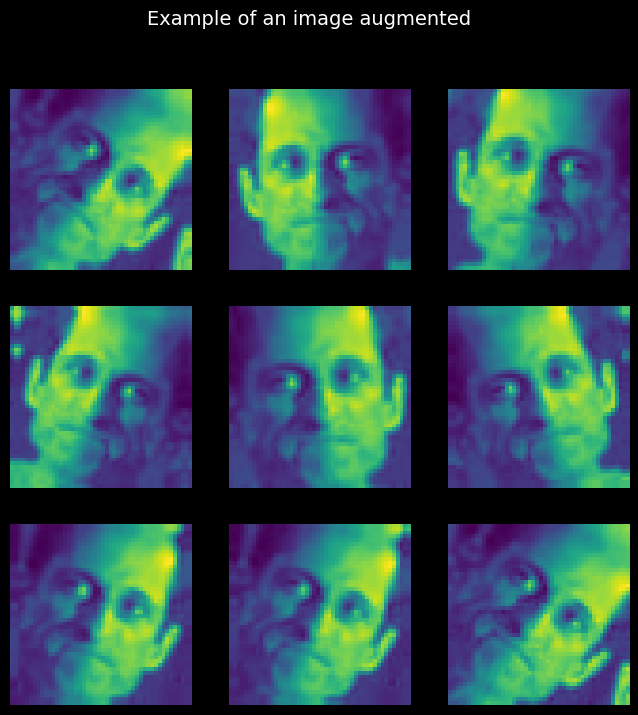

In [4]:
showcase_augmented_image(train_ds, data_augmentation)

# Sequential Model Architecture

## Shallow CNN Sequence

In [5]:
shallow_sequence = [
    #preproccesing data
    data_augmentation,
    
    #Standardize the data
    layers.Rescaling(1./255), #convert pixel data to floats (between 0 and 1)
    
    #layer 1
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"), #stride size = 1
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    #layer 2
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"), #stride size = 1
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    #FC layer
    layers.Flatten(),
    layers.Dense(512, activation='relu'),

    #logistic layer
    layers.Dense(num_cat, activation='softmax')

]

## Deep CNN Sequence

In [6]:
deep_sequence = [
    #preproccesing data
    data_augmentation,
    
    #Standardize the data
    layers.Rescaling(1./255), #convert pixel data to floats (between 0 and 1)
    
    #layer 1
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'), #stride size = 1
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    #layer 2
    layers.Conv2D(128, kernel_size=(5, 5), activation="relu", padding='same'), #stride size = 1
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    #layer 3
    layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding='same'), #stride size = 1
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    #layer 4
    layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding='same'), #stride size = 1
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),


    #FC layer 1
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

      #FC layer 1
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    #logistic layer
    layers.Dense(num_cat, activation='softmax')

  ]

## Compile the model

In [7]:
def facial_expr_model(sequence):
    model = keras.Sequential(sequence)
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [23]:
#shallow sequence
shallow_model = facial_expr_model(shallow_sequence)
print(shallow_model.summary()     )             

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 48, 48, 1)         0         
                                                                 
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)       

In [19]:
#deep sequence
epochs_num = 40

deep_model = facial_expr_model(deep_sequence)
deep_model.summary()   

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 48, 48, 1)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 64)       

## Training Model

### Fitting model

In [10]:
# #fitting shallow sequence
# shallow_history = shallow_model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs_num
# )

#fitting deep sequence
deep_history = deep_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs_num
)

Epoch 1/40
1374/1374 [==============================] - 770s 559ms/step - loss: 2.0225 - accuracy: 0.2242 - val_loss: 1.7637 - val_accuracy: 0.2839
Epoch 2/40
1374/1374 [==============================] - 757s 551ms/step - loss: 1.8068 - accuracy: 0.2782 - val_loss: 1.6968 - val_accuracy: 0.3383
Epoch 3/40
1374/1374 [==============================] - 665s 484ms/step - loss: 1.6874 - accuracy: 0.3324 - val_loss: 2.5639 - val_accuracy: 0.3265
Epoch 4/40
1374/1374 [==============================] - 667s 486ms/step - loss: 1.5986 - accuracy: 0.3710 - val_loss: 1.6221 - val_accuracy: 0.3807
Epoch 5/40
1374/1374 [==============================] - 674s 491ms/step - loss: 1.5128 - accuracy: 0.4113 - val_loss: 1.4009 - val_accuracy: 0.4751
Epoch 6/40
1374/1374 [==============================] - 673s 490ms/step - loss: 1.4625 - accuracy: 0.4338 - val_loss: 1.3280 - val_accuracy: 0.4951
Epoch 7/40
1374/1374 [==============================] - 656s 478ms/step - loss: 1.4296 - accuracy: 0.4518 - val_

### Save model and training history

In [10]:
def save_model(model, depth, epoch_count):
    model.save(f'my_model_{depth}_{epoch_count}_epochs', save_format='h5')
    
def save_training_history(history, depth):
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 
    
    #save to csv: 
    hist_csv_file = f'{depth}_model_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

In [12]:
# save_model(shallow_model, 'shallow', epochs_num)
# save_training_history(shallow_history, 'shallow')

save_model(deep_model, 'deep_m_', epochs_num)
save_training_history(deep_history, 'deep_m_')

### Load Pre-Trained models and Training History
Due to my miminal perofmance computer, I trained my model utilizing google collab's GPU computational power.

In [20]:
shallow_model = load_model('model/my_model_shallow_50_epochs')
shallow_hist_df = pd.read_csv('model/shallow_model_history.csv')

deep_model = load_model('model/my_model_deep_m__40_epochs')
deep_hist_df = pd.read_csv('model/deep_m__model_history.csv')

# Evaluate and Visualize Training Results.


412/412 - 8s - loss: 1.3638 - accuracy: 0.5047 - 8s/epoch - 19ms/step

Shallow CNN Model
Accuracy: 50.47% 
Loss:  1.36


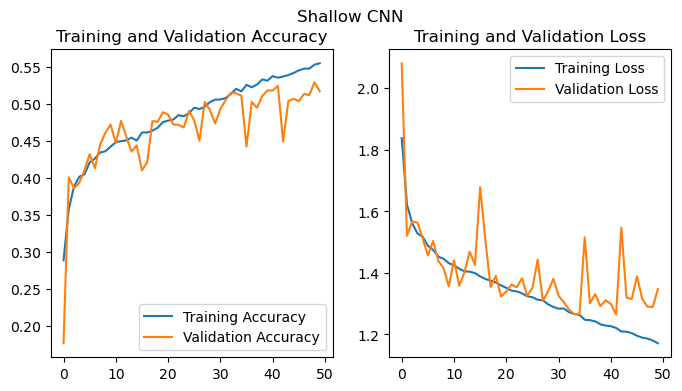

412/412 [==============================] - 9s 22ms/step


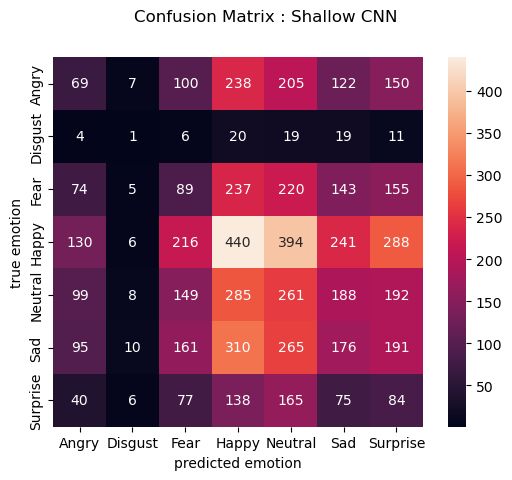

In [13]:
eval_model_stats(shallow_model, 'Shallow CNN', test_ds)
plot_model_peformance_from_df(shallow_hist_df, 50, 'Shallow CNN')
create_confusion_matrix(test_ds, shallow_model, class_names, 'Shallow CNN')

412/412 - 79s - loss: 1.1604 - accuracy: 0.5535 - 79s/epoch - 191ms/step

Deep CNN Model
Accuracy: 55.35% 
Loss:  1.16


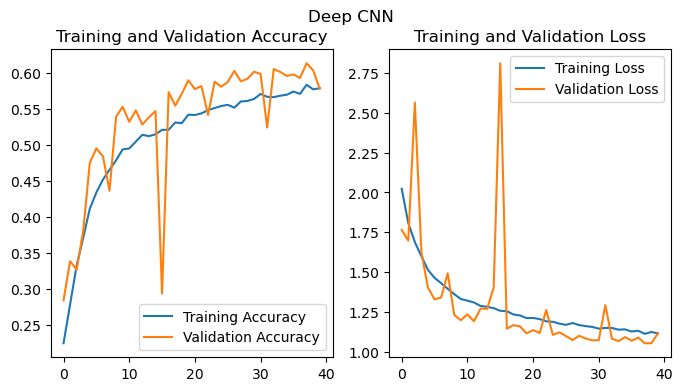

412/412 [==============================] - 81s 197ms/step


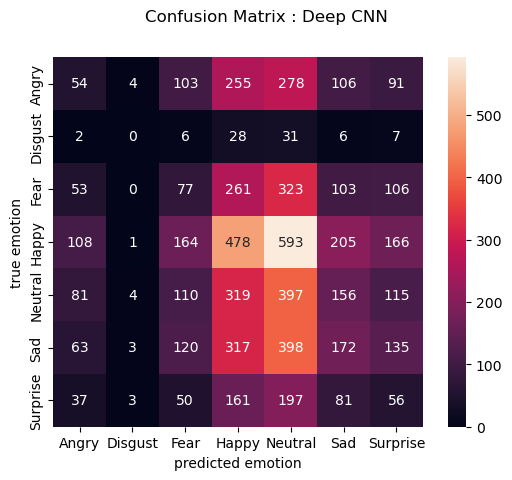

In [21]:
eval_model_stats(deep_model, 'Deep CNN', test_ds)
plot_model_peformance_from_df(deep_hist_df, epochs_num, 'Deep CNN')
create_confusion_matrix(test_ds, deep_model, class_names, 'Deep CNN')